In [1]:
import mne
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage
from mne import Epochs, EvokedArray, create_info, io, pick_types, read_events
from mne.datasets import sample
from mne.decoding import Vectorizer
from mne.decoding import CSP

import torch
from torcheeg.models import EEGNet, LSTM, VanillaTransformer
from torcheeg.models import DGCNN
from torcheeg import transforms
from torcheeg.transforms import ToGrid

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from matplotlib import cm
import matplotlib.colors as colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


/home/aurelien.stumpf/Development/BCI_Classification/eeg_env/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
import sys 
sys.path.append("/home/aurelien.stumpf/Development/BCI_Classification/")
from eeg_project_package import dataset, models, spectral_analysis, training

In [23]:
import importlib
importlib.reload(dataset)
importlib.reload(training)
importlib.reload(models)
importlib.reload(spectral_analysis)

<module 'eeg_project_package.spectral_analysis' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/spectral_analysis.py'>

## Utils

In [3]:
def get_positions_from_channel_list(channel_list, montage):
    dict_positions = montage.get_positions()["ch_pos"]
    positions = {}
    for channel in channel_list:
        positions[channel] = dict_positions[channel]
    return positions

montage = mne.channels.make_standard_montage('standard_1020')

## Check Loading of Braccio Dataset Files

Number of channels:  64
Number of samples:  64


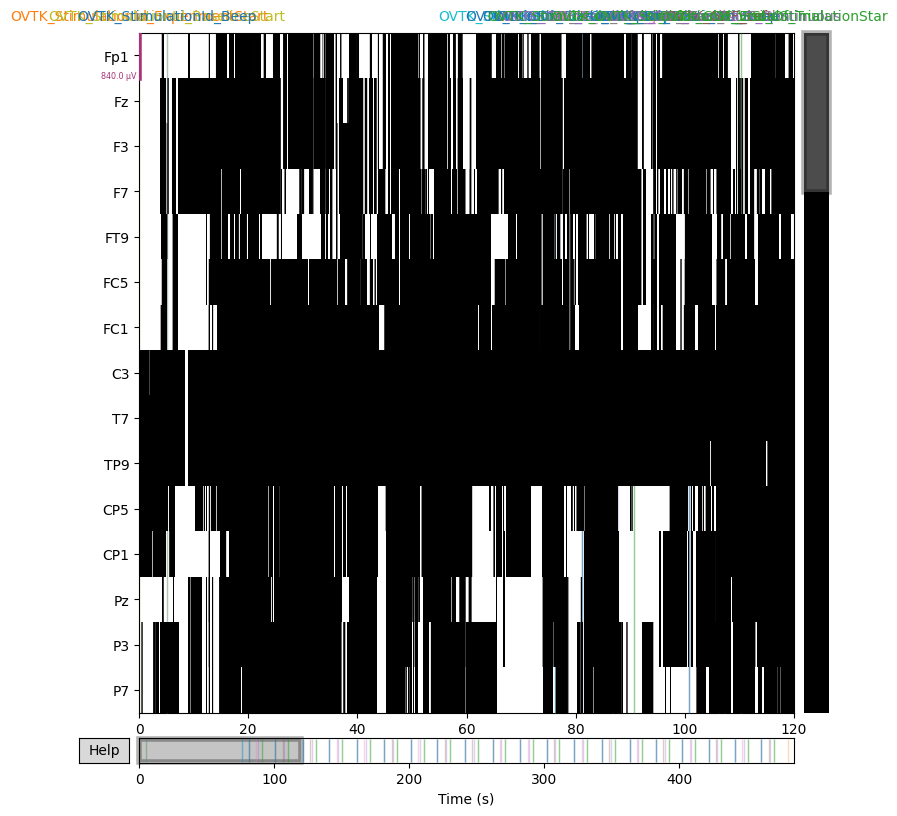

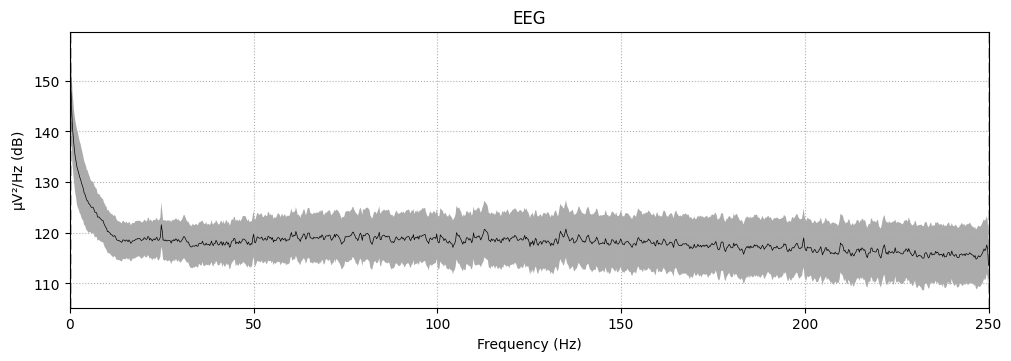

In [4]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
input_fname1 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-17.46.29].edf"
#Read raw data files where each file contains a run
raws = read_raw_edf(input_fname1, preload=True)
#Combine all loaded runs
#raw_obj = concatenate_raws(raws)
raw_obj = raws

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data)))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

# list of all channel names
list_all_ch_names = raw_obj.ch_names

## Multi-Subject Classif

In [5]:
# Define the subject and the session
task_type = "imaginary_left/right"
folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/"

num_sessions = [1,2,3]
num_train_subjects = [1,2,3,5,6,7]   
num_test_subjects = [8,10,11,13,14]
list_labels = ['OVTK_GDF_Left','OVTK_GDF_Right']

# Define the channels
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
list_idx_channels = [list_all_ch_names.index(ch) for ch in list_name_channels]

# Define the labels
labels = ['OVTK_GDF_Left', 'OVTK_GDF_Right']

# Define the parameters of the dataset
feature_type = ["time"]
dict_preprocessing = {"polynomial_degree":None,"tmin":0,"tmax":4}
dict_features = {"type_psd":"welch","fs":500,"nfft":300,"noverlap":150,"nperseg":300,"filter_order":19,"fmin":4,"fmax":30}

# Create the dataset
trainset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_train_subjects, num_sessions, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = feature_type, dict_preprocessing = dict_preprocessing, dict_features = dict_features)
testset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_test_subjects, num_sessions, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = feature_type, dict_preprocessing = dict_preprocessing, dict_features = dict_features)

Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-01/EEG/Test-[2022.03.15-16.39.19].edf
could not convert string to float: './.).(-*'
Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-02/EEG/Train-[2022.04.04-16.15.17].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationId_ExperimentStart, OVTK_StimulationId_BaselineStart/OVTK_StimulationId_Beep'
Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-02/EEG/Train-[2022.04.04-16.14.01].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationId_ExperimentStart, OVTK_StimulationId_BaselineStart/OVTK_StimulationId_Beep'
Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-02/EEG/Test-[2022.04.04-16.52.15].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_GDF_Feedb

# LDA

In [16]:
X_train = trainset.features["band_psd"].reshape(trainset.features["band_psd"].shape[0], -1)
y_train = trainset.labels
X_test = testset.features["band_psd"].reshape(testset.features["band_psd"].shape[0], -1)
y_test = testset.labels

# Train LDA classifier
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)
y_pred = lda_clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("LDA accuracy: ", acc)

# Train SVM classifier
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("SVM accuracy: ", acc)

# Train SVM classifier
svm_clf = SVC(kernel='rbf')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("rbf SVM accuracy: ", acc)

LDA accuracy:  0.572742474916388
SVM accuracy:  0.5903010033444817
rbf SVM accuracy:  0.5418060200668896


In [5]:
X = trainset.features["band_psd"]
labels = trainset.labels

# Create classification pipeline
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
clf = make_pipeline(csp, lda)

# Cross validator
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

# Do cross-validation
preds = np.empty(len(labels))
for train, test in cv.split(X, labels):
    clf.fit(X[train], labels[train])
    preds[test] = clf.predict(X[test])

# Classification report
print(classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.60      0.57      0.58        70
         1.0       0.59      0.61      0.60        70

    accuracy                           0.59       140
   macro avg       0.59      0.59      0.59       140
weighted avg       0.59      0.59      0.59       140



# EEGNet

In [8]:
trainset.transform_dataset_numpy_to_torch()
trainset.features["time"] = trainset.features["time"].unsqueeze(1)
testset.transform_dataset_numpy_to_torch()
testset.features["time"] = testset.features["time"].unsqueeze(1)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, num_workers=2)

In [9]:
feature_type = "time"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = EEGNet(chunk_size=2001,
               num_electrodes=12,
               dropout=0,
               kernel_1=500,
               kernel_2=16,
               F1=16,
               F2=16,
               D=2,
               num_classes=2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.98)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
scheduler_dict = {"MultiplicativeLR":scheduler1} #, "ReduceLROnPlateau":scheduler2}
logs = training.train_model(model, trainloader, testloader, device, criterion, feature_type, 101, optimizer, scheduler_dict, print_epoch = 5)

Epoch 0:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 0
lr:  0.01
-------------------------
Train set: Avg. loss: 0.0465, Balanced Accuracy: 0.4673454761505127 (47%)
Test set: Avg. loss: 0.0452, Balanced Accuracy: 0.48049724102020264 (48%)
-------------------------


Epoch 5:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 5
lr:  0.009039207967999998
-------------------------
Train set: Avg. loss: 0.0359, Balanced Accuracy: 0.7110252976417542 (71%)
Test set: Avg. loss: 0.0437, Balanced Accuracy: 0.580673098564148 (58%)
-------------------------


Epoch 10:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 10
lr:  0.008170728068875466
-------------------------
Train set: Avg. loss: 0.0288, Balanced Accuracy: 0.786165714263916 (79%)
Test set: Avg. loss: 0.0416, Balanced Accuracy: 0.6629928946495056 (66%)
-------------------------


Epoch 15:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 15
lr:  0.007385691026454037
-------------------------
Train set: Avg. loss: 0.0256, Balanced Accuracy: 0.8096910119056702 (81%)
Test set: Avg. loss: 0.0433, Balanced Accuracy: 0.6513423919677734 (65%)
-------------------------


Epoch 20:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 20
lr:  0.006676079717550942
-------------------------
Train set: Avg. loss: 0.0235, Balanced Accuracy: 0.8469101190567017 (85%)
Test set: Avg. loss: 0.0433, Balanced Accuracy: 0.6593006253242493 (66%)
-------------------------


Epoch 20:  47%|████▋     | 84/178 [00:10<00:11,  8.39batch/s, accuracy=0.842, loss=0.0108] 


KeyboardInterrupt: 

In [10]:
compteur = 0
for param in model.parameters():
    print(param.data.shape)
    if compteur == 0:
        time_filters = param.data.cpu().numpy()
    compteur += 1

torch.Size([16, 1, 1, 500])
torch.Size([16])
torch.Size([16])
torch.Size([32, 1, 12, 1])
torch.Size([32])
torch.Size([32])
torch.Size([32, 1, 1, 16])
torch.Size([16, 32, 1, 1])
torch.Size([16])
torch.Size([16])
torch.Size([2, 992])


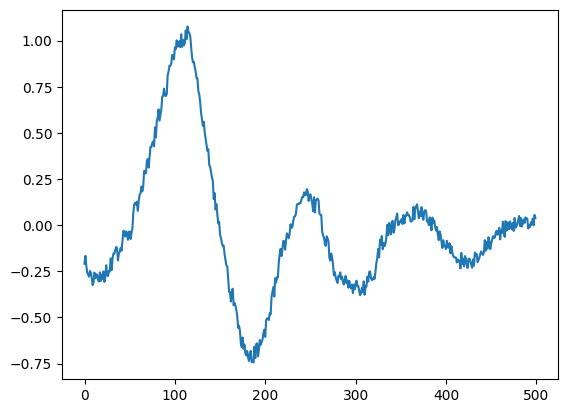

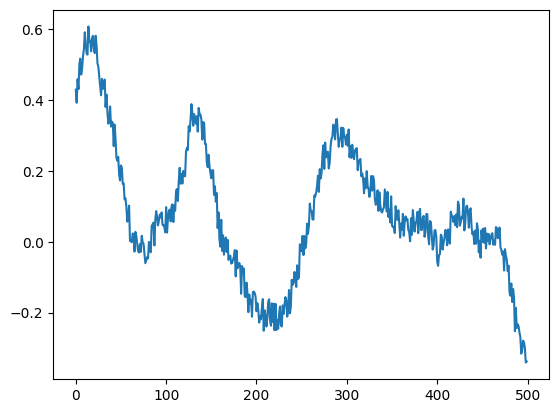

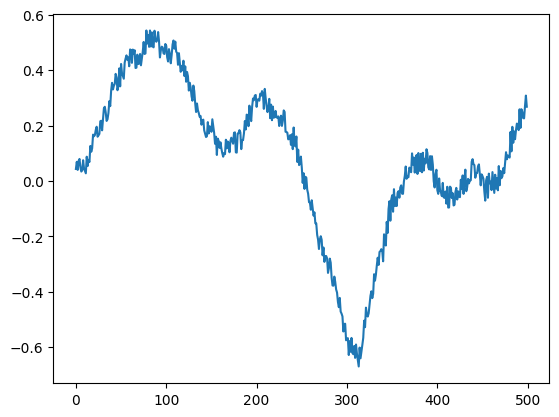

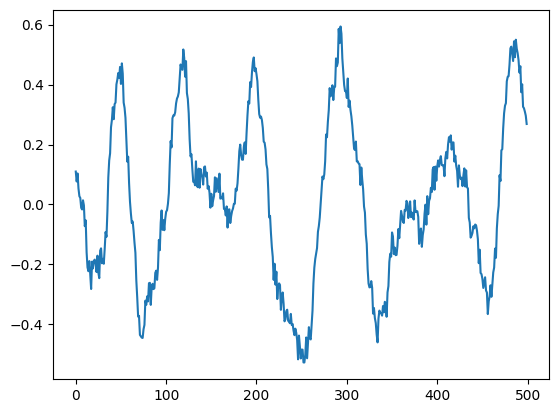

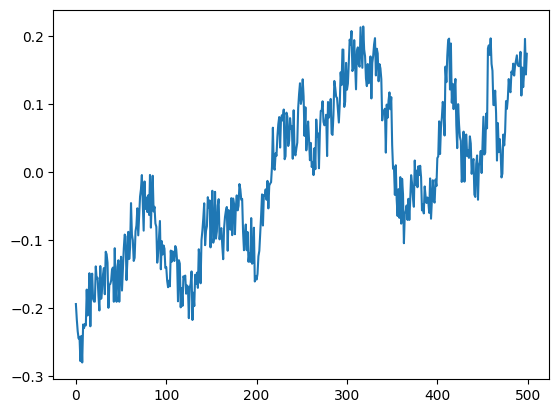

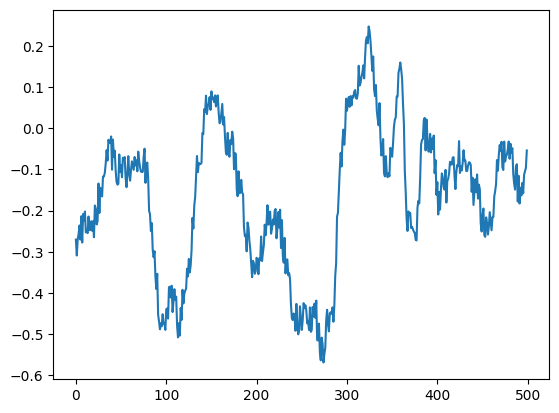

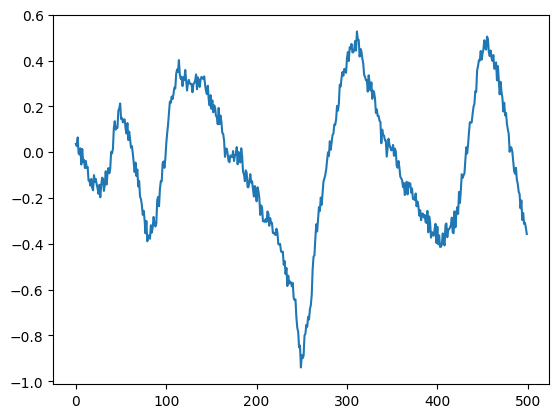

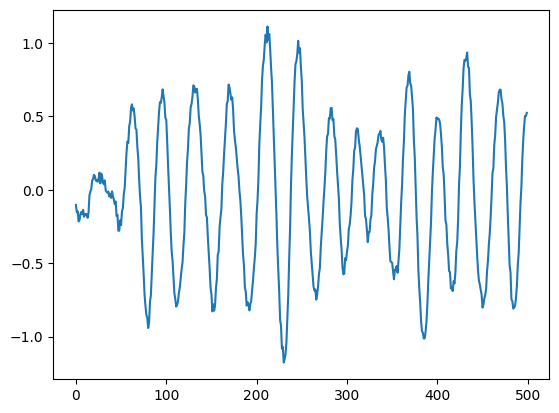

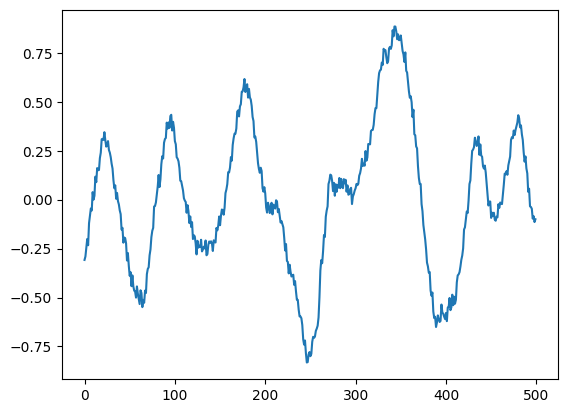

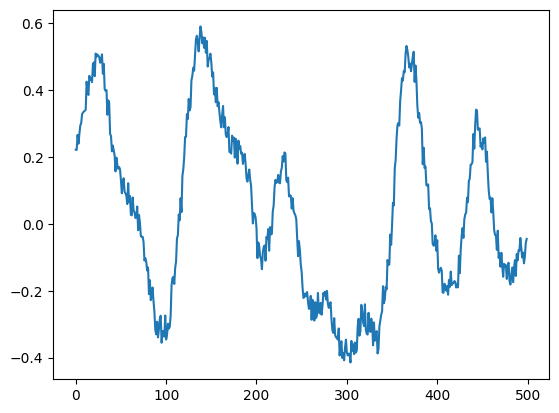

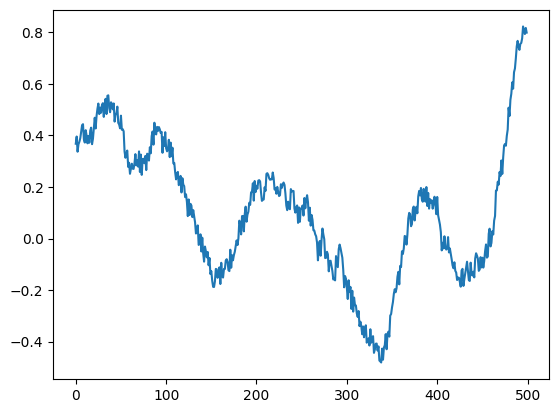

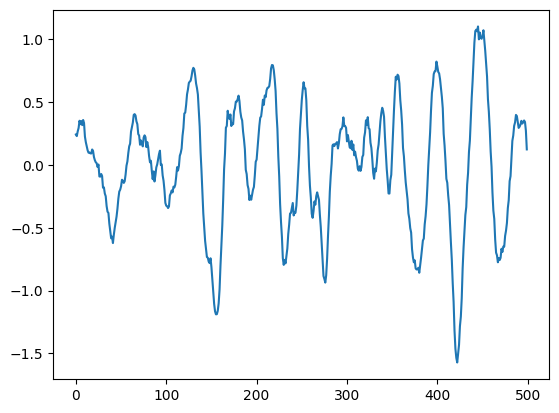

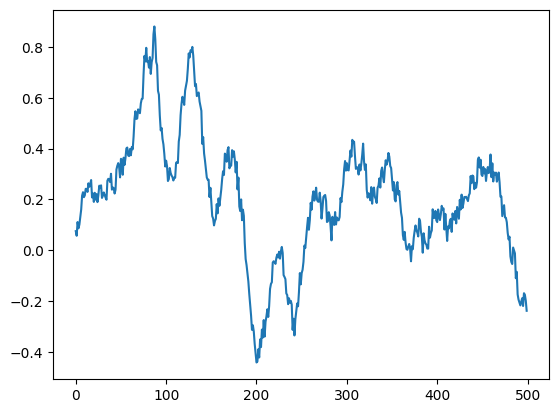

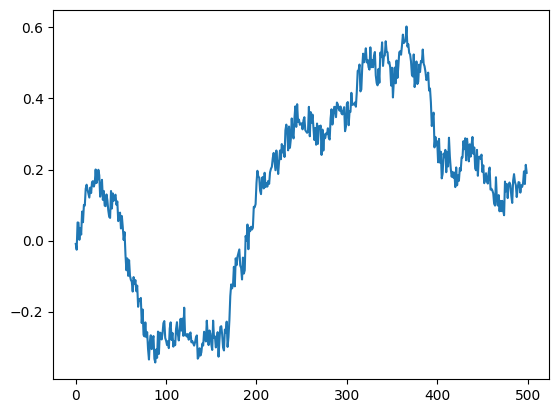

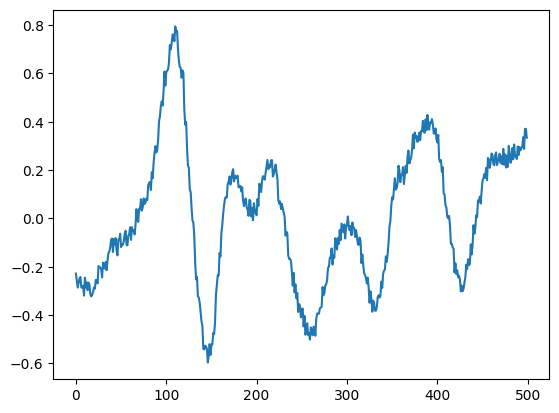

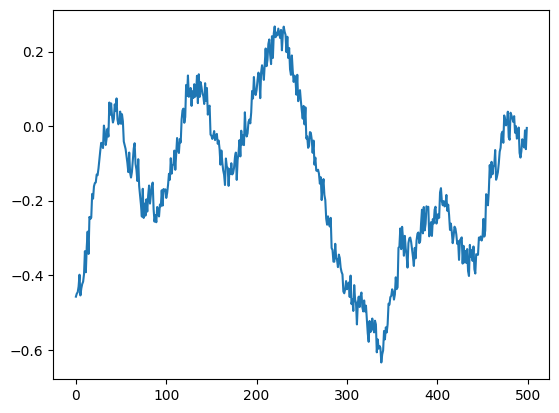

In [11]:
time_filters = time_filters.reshape(16, 500)
for i in range(16):
    plt.plot(time_filters[i])
    plt.show()

# LSTM

In [73]:
trainset.features["time"].shape

torch.Size([100, 1, 12, 2001])

In [12]:
trainset.transform_dataset_numpy_to_torch()
trainset.features["time"] = trainset.features["time"].squeeze(1)
testset.transform_dataset_numpy_to_torch()
testset.features["time"] = testset.features["time"].squeeze(1)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, num_workers=2)

In [13]:
feature_type = "time"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = LSTM(num_electrodes=12, hid_channels=64, num_classes=2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
scheduler_dict = {"MultiplicativeLR":scheduler1, "ReduceLROnPlateau":scheduler2}
logs = training.train_model(model, trainloader, testloader, device, criterion, feature_type, 21, optimizer, scheduler_dict, print_epoch = 10)

Epoch 0:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 0
lr:  0.01
-------------------------
Train set: Avg. loss: 0.0435, Balanced Accuracy: 0.49473315477371216 (49%)
Test set: Avg. loss: 0.0435, Balanced Accuracy: 0.504014253616333 (50%)
-------------------------


Epoch 10:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 10
lr:  0.005987369392383786
-------------------------
Train set: Avg. loss: 0.0347, Balanced Accuracy: 0.7198033332824707 (72%)
Test set: Avg. loss: 0.0456, Balanced Accuracy: 0.5334179401397705 (53%)
-------------------------


Epoch 20:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 20
lr:  0.0035848592240854188
-------------------------
Train set: Avg. loss: 0.0151, Balanced Accuracy: 0.8908005952835083 (89%)
Test set: Avg. loss: 0.0873, Balanced Accuracy: 0.5296354293823242 (53%)
-------------------------


Epoch 20: 100%|██████████| 178/178 [00:48<00:00,  3.69batch/s, accuracy=0.888, loss=0.0156]  


# COrrMLP

In [76]:
x = torch.zeros((120, 12, 2001))
A = torch.zeros((10,2001))
xA = torch.einsum('ijk,lk->iljk', x, A)
print(xA.shape)
xA = xA.reshape(120, 12*10, 2001)
xAx = torch.bmm(xA, x.permute(0,2,1)).reshape(120, 10, 12, 12)
xAx.shape

torch.Size([120, 10, 12, 2001])


torch.Size([120, 10, 12, 12])

In [69]:
torch.einsum('ijk,lk->iljk', x, A).shape

torch.Size([120, 10, 12, 2001])

In [59]:
(x * A).shape

torch.Size([120, 12, 2001])

In [21]:
model

LSTM(
  (gru_layer): LSTM(12, 64, num_layers=2, batch_first=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)

In [19]:
trainset.features["time"].shape

(2848, 12, 2001)

In [14]:
model.q1.shape

torch.Size([1, 2001])

In [9]:
trainset.transform_dataset_numpy_to_torch()
testset.transform_dataset_numpy_to_torch()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, num_workers=2)

In [29]:
feature_type = "time"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = models.Corr_MLP(n_channels = 12,n_filters = 20, time_dim = 2001, layer_size_list = [10,2], non_linearity="relu", initialization="kaiming")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.98)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
scheduler_dict = {"MultiplicativeLR":scheduler1}
logs = training.train_model(model, trainloader, testloader, device, criterion, feature_type, 151, optimizer, scheduler_dict, print_epoch = 5)

Epoch 0:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 0
lr:  0.0005
-------------------------


Train set: Avg. loss: 21.3673, Balanced Accuracy: 0.5045645833015442 (50%)
Test set: Avg. loss: 8.2147, Balanced Accuracy: 0.5147425532341003 (51%)
-------------------------


Epoch 5:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 5
lr:  0.0004519603983999999
-------------------------
Train set: Avg. loss: 1.3908, Balanced Accuracy: 0.6576545238494873 (66%)
Test set: Avg. loss: 1.5867, Balanced Accuracy: 0.5380155444145203 (54%)
-------------------------


Epoch 10:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 10
lr:  0.00040853640344377327
-------------------------
Train set: Avg. loss: 0.4823, Balanced Accuracy: 0.7398173809051514 (74%)
Test set: Avg. loss: 1.1079, Balanced Accuracy: 0.5301496386528015 (53%)
-------------------------


Epoch 15:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 15
lr:  0.0003692845513227018
-------------------------
Train set: Avg. loss: 0.8735, Balanced Accuracy: 0.6952247619628906 (70%)
Test set: Avg. loss: 1.9607, Balanced Accuracy: 0.5540458559989929 (55%)
-------------------------


Epoch 20:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 20
lr:  0.0003338039858775471
-------------------------
Train set: Avg. loss: 0.2035, Balanced Accuracy: 0.7682584524154663 (77%)
Test set: Avg. loss: 0.6982, Balanced Accuracy: 0.564802885055542 (56%)
-------------------------


Epoch 25:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 25
lr:  0.00030173236488944833
-------------------------
Train set: Avg. loss: 0.0621, Balanced Accuracy: 0.84375 (84%)
Test set: Avg. loss: 0.5178, Balanced Accuracy: 0.5605621337890625 (56%)
-------------------------


Epoch 30:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 30
lr:  0.00027274215969121844
-------------------------
Train set: Avg. loss: 0.0400, Balanced Accuracy: 0.8602527976036072 (86%)
Test set: Avg. loss: 0.3830, Balanced Accuracy: 0.5489116907119751 (55%)
-------------------------


Epoch 35:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 35
lr:  0.00024653731030903895
-------------------------
Train set: Avg. loss: 0.0992, Balanced Accuracy: 0.807935357093811 (81%)
Test set: Avg. loss: 0.4671, Balanced Accuracy: 0.5522701740264893 (55%)
-------------------------


Epoch 40:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 40
lr:  0.00022285020197547535
-------------------------
Train set: Avg. loss: 0.0106, Balanced Accuracy: 0.9427668452262878 (94%)
Test set: Avg. loss: 0.2965, Balanced Accuracy: 0.5530643463134766 (55%)
-------------------------


Epoch 45:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 45
lr:  0.00020143893213671262
-------------------------
Train set: Avg. loss: 0.0122, Balanced Accuracy: 0.9332865476608276 (93%)
Test set: Avg. loss: 0.2821, Balanced Accuracy: 0.5534477829933167 (55%)
-------------------------


Epoch 50:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 50
lr:  0.00018208484004355837
-------------------------
Train set: Avg. loss: 0.0307, Balanced Accuracy: 0.7910814881324768 (79%)
Test set: Avg. loss: 0.0859, Balanced Accuracy: 0.5523141622543335 (55%)
-------------------------


Epoch 55:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 55
lr:  0.0001645902736973738
-------------------------
Train set: Avg. loss: 0.0184, Balanced Accuracy: 0.8792134523391724 (88%)
Test set: Avg. loss: 0.1047, Balanced Accuracy: 0.555949866771698 (56%)
-------------------------


Epoch 60:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 60
lr:  0.00014877657134606016
-------------------------
Train set: Avg. loss: 0.0182, Balanced Accuracy: 0.889396071434021 (89%)
Test set: Avg. loss: 0.1091, Balanced Accuracy: 0.5572826862335205 (56%)
-------------------------


Epoch 65:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 65
lr:  0.00013448223691630274
-------------------------
Train set: Avg. loss: 0.0309, Balanced Accuracy: 0.822331428527832 (82%)
Test set: Avg. loss: 0.1372, Balanced Accuracy: 0.5420877933502197 (54%)
-------------------------


Epoch 70:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 70
lr:  0.00012156129074883073
-------------------------
Train set: Avg. loss: 0.0109, Balanced Accuracy: 0.9427669048309326 (94%)
Test set: Avg. loss: 0.1082, Balanced Accuracy: 0.5459436178207397 (55%)
-------------------------


Epoch 75:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 75
lr:  0.00010988177879371954
-------------------------
Train set: Avg. loss: 0.0064, Balanced Accuracy: 0.9750702381134033 (98%)
Test set: Avg. loss: 0.1400, Balanced Accuracy: 0.5463550686836243 (55%)
-------------------------


Epoch 80:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 80
lr:  9.93244250410203e-05
-------------------------
Train set: Avg. loss: 0.0037, Balanced Accuracy: 0.990519642829895 (99%)
Test set: Avg. loss: 0.1685, Balanced Accuracy: 0.5488550662994385 (55%)
-------------------------


Epoch 85:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 85
lr:  8.978141342478093e-05
-------------------------
Train set: Avg. loss: 0.0030, Balanced Accuracy: 0.9912219047546387 (99%)
Test set: Avg. loss: 0.1795, Balanced Accuracy: 0.543030858039856 (54%)
-------------------------


Epoch 87:  94%|█████████▍| 168/178 [00:01<00:00, 116.99batch/s, accuracy=0.996, loss=0.00214]


KeyboardInterrupt: 

In [50]:
model

Corr_MLP(
  (l1): Linear(in_features=144, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=2, bias=True)
)

In [30]:
compteur = 0
for param in model.parameters():
    print(param.data.shape)
    corr_matrix = param.data.cpu().numpy()
    break

torch.Size([20, 2001])


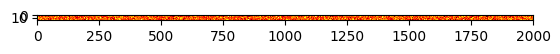

In [31]:
plt.imshow(corr_matrix, cmap='hot', interpolation='nearest')
plt.show()

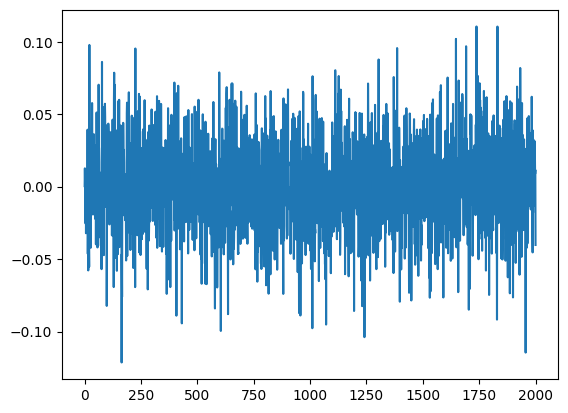

In [32]:
plt.plot(corr_matrix[0])
plt.show()